<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_2_Fix_CNN_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title INSTALLS
!pip install livelossplot --quiet

In [2]:
#@title IMPORTS
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
#helpers
import os
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [3]:
#@title Setting up GPU -- Runtime -> Change runtime type
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [4]:
#@title DOWNLOADING DATA
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize(256),
                            transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.FashionMNIST(root='./data',train=True, 
                       transform=trans, download=True)
test_set = dset.FashionMNIST(root='./data',train=False, 
                      transform=trans, download=True)

print(train_set)
print(test_set)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=256, interpolation=bilinear)
               Normalize(mean=(0.5,), std=(1.0,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=256, interpolation=bilinear)
               Normalize(mean=(0.5,), std=(1.0,))
           )


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#@title Hyperparameters
batch_size = 256
learning_rate = .001
betas = (0.9, .5)
epochs = 5

In [6]:
#@title SETUP DATALOADERS
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print(len(train_loader))
print(len(test_loader))

235
40


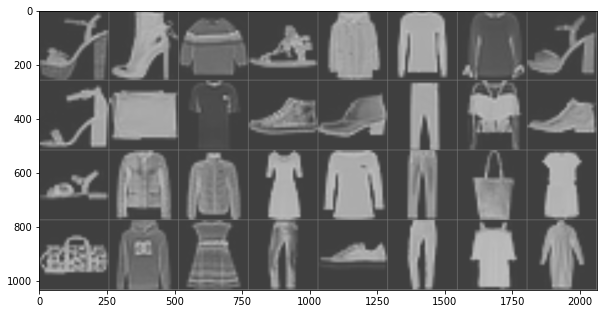

In [7]:
#@title PREVIEW THE DATA
def imshow(img):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
channels = images.shape[1]
imshow(torchvision.utils.make_grid(images[:32], nrow=8))

In [8]:
#@title Define the Model
class ConvNet(nn.Module):
  def __init__(self, channels):
    super(ConvNet, self).__init__()

    def conv_block(in_filters, out_filters, bn=True, pool=True, drop=False):
      block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                nn.LeakyReLU(0.2, inplace=True)]
      if pool:
        block.append(nn.MaxPool2d(kernel_size=2, stride=2))
      if drop:
        block.append(nn.Dropout2d(.5))
      if bn:
          block.append(nn.BatchNorm2d(out_filters))
      return block

    self.model = nn.Sequential(
      *conv_block(channels, 32, bn=False, pool=True, drop=False),
      *conv_block(32, 64, pool=True, drop=False),
      *conv_block(64, 128, pool=True, drop=False),
      *conv_block(128, 256, pool=True, drop=False),  
      nn.Flatten(),
      nn.Linear(256, 128),
      nn.Linear(128, 10) 
    )    

  def forward(self, x):
    x = self.model(x)
    output = F.log_softmax(x, dim=1)
    return output

In [9]:
#@title MODEL
model = ConvNet(channels)
print(model)

ConvNet(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): MaxPool2d(

In [10]:
#@title OPTIMIZER and LOSS FUNCTION
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)
loss_fn = nn.CrossEntropyLoss()

if cuda:
  loss_fn.cuda()
  model.cuda()

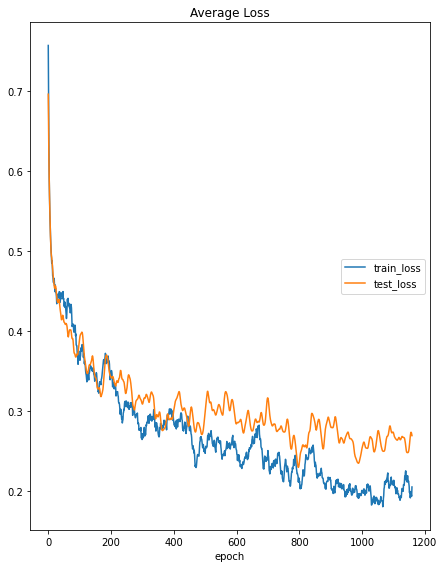

Average Loss
	train_loss       	 (min:    0.180, max:    0.757, cur:    0.205)
	test_loss        	 (min:    0.230, max:    0.696, cur:    0.269)


In [11]:
#@title TRAINING
groups = {'Average Loss': ['train_loss', 'test_loss']}
liveloss = PlotLosses(groups=groups)
history={}
running_train_loss = []
running_test_loss = []
iterations = 0
avg = 15

for epoch in range(epochs):    
  for batch_idx, (x, y) in enumerate(train_loader):
    iterations += 1       
    x, y = Variable(x.type(FloatTensor)), Variable(y.type(LongTensor))

    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

    running_train_loss.append(loss.data)        
    
    x_test, y_test = iter(test_loader).next()
    y_pred_test = model(Variable(x_test.type(FloatTensor)))
    loss_test = loss_fn(y_pred_test, y_test.type(LongTensor))
    running_test_loss.append(loss_test.data)
    if iterations > avg:
      history['train_loss'] = sum(running_train_loss[iterations-avg:iterations])/avg
      history['test_loss'] = sum(running_test_loss[iterations-avg:iterations])/avg  

      liveloss.update(history)
      liveloss.send() 
  

In [16]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images, labels in test_loader:    
        images = Variable(images.type(FloatTensor))   
        labels = Variable(labels.type(LongTensor))

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)       
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
class_correct = np.array(class_correct)
class_total = np.array(class_total)
print("Average accuracy %2d %%" % (100*np.mean(class_correct/class_total)))
std = np.std(class_correct/class_total)*100
print("Standard Deviation %2.2f %%" % (std))

Accuracy of T-shirt/top : 82 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 81 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 91 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 71 %
Accuracy of Sneaker : 97 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 95 %
Average accuracy 90 %
Standard Deviation 8.84 %
